In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 170M/170M [00:02<00:00, 68.8MB/s]


In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim=3072, latent_dim=128):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )
    kl_div = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )
    return recon_loss + kl_div, recon_loss, kl_div

In [5]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 15

total_losses = []
recon_losses = []
kl_losses = []

for epoch in range(epochs):
    model.train()
    running_total = 0
    running_recon = 0
    running_kl = 0

    for images, _ in loader:
        images = images.view(images.size(0), -1).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(images)

        loss, recon_loss, kl_loss = vae_loss(
            recon, images, mu, logvar
        )

        loss.backward()
        optimizer.step()

        running_total += loss.item()
        running_recon += recon_loss.item()
        running_kl += kl_loss.item()

    total_losses.append(running_total / len(loader.dataset))
    recon_losses.append(running_recon / len(loader.dataset))
    kl_losses.append(running_kl / len(loader.dataset))

    print(f"Epoch {epoch+1}: "
          f"Total {total_losses[-1]:.4f}, "
          f"Recon {recon_losses[-1]:.4f}, "
          f"KL {kl_losses[-1]:.4f}")

Epoch 1: Total 1988.7599, Recon 1971.6967, KL 17.0632
Epoch 2: Total 1943.1608, Recon 1927.6274, KL 15.5334
Epoch 3: Total 1925.7450, Recon 1909.9515, KL 15.7935
Epoch 4: Total 1903.9786, Recon 1885.3739, KL 18.6047
Epoch 5: Total 1889.0783, Recon 1869.4999, KL 19.5784
Epoch 6: Total 1880.6914, Recon 1861.6482, KL 19.0432
Epoch 7: Total 1874.0309, Recon 1854.4354, KL 19.5956
Epoch 8: Total 1869.2598, Recon 1849.1851, KL 20.0747
Epoch 9: Total 1867.0703, Recon 1847.1657, KL 19.9045
Epoch 10: Total 1865.5312, Recon 1845.7012, KL 19.8300
Epoch 11: Total 1864.2069, Recon 1844.5361, KL 19.6708
Epoch 12: Total 1862.3428, Recon 1842.4165, KL 19.9263
Epoch 13: Total 1860.2924, Recon 1839.9152, KL 20.3772
Epoch 14: Total 1857.8778, Recon 1836.9677, KL 20.9100
Epoch 15: Total 1855.4948, Recon 1834.2604, KL 21.2344


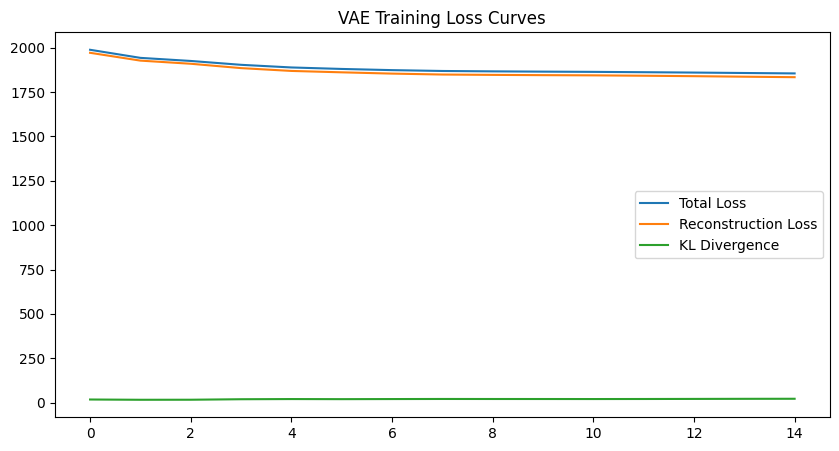

In [6]:
plt.figure(figsize=(10,5))
plt.plot(total_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction Loss")
plt.plot(kl_losses, label="KL Divergence")
plt.legend()
plt.title("VAE Training Loss Curves")
plt.show()

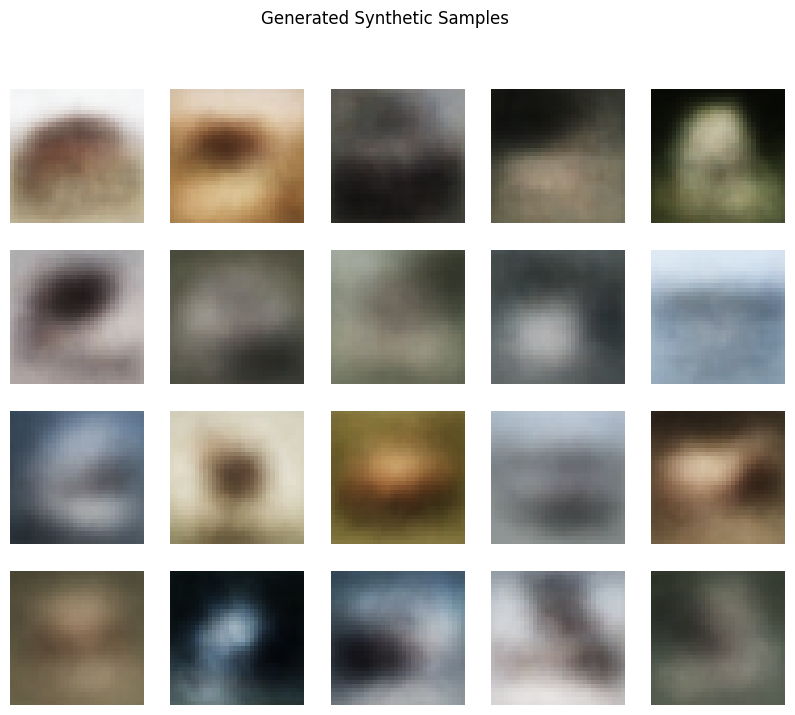

In [7]:
model.eval()

with torch.no_grad():
    z = torch.randn(20, 128).to(device)
    generated = model.decode(z).cpu()
    generated = generated.view(-1, 3, 32, 32)

fig, axes = plt.subplots(4,5, figsize=(10,8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated[i].permute(1,2,0))
    ax.axis("off")

plt.suptitle("Generated Synthetic Samples")
plt.show()

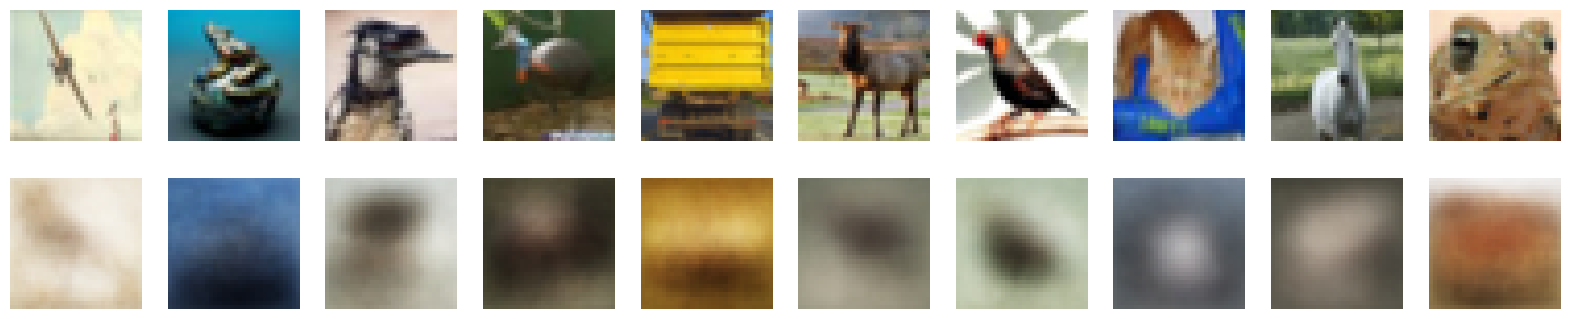

In [8]:
images, _ = next(iter(loader))
images = images[:10].to(device)

with torch.no_grad():
    recon, _, _ = model(images.view(images.size(0), -1))

recon = recon.view(-1,3,32,32).cpu()

fig, axes = plt.subplots(2,10, figsize=(20,4))

for i in range(10):
    axes[0,i].imshow(images[i].cpu().permute(1,2,0))
    axes[0,i].axis("off")
    axes[1,i].imshow(recon[i].permute(1,2,0))
    axes[1,i].axis("off")

axes[0,0].set_ylabel("Original")
axes[1,0].set_ylabel("Reconstructed")

plt.show()